<a href="https://colab.research.google.com/github/NobodydeBunny/Cat_Dog_breed_classifire_AI_model/blob/main/Dogs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [25]:
(dataset, info) = tfds.load("oxford_iiit_pet",
                            with_info=True,
                            as_supervised=True)

train_ds = dataset['train']
test_ds = dataset['test']

class_names = info.features['label'].names

In [26]:
dog_labels = tf.constant(
    [i for i, name in enumerate(class_names) if name[0].islower()], dtype=tf.int64
)

def is_dog(image, label):
    return tf.reduce_any(tf.equal(dog_labels, label))

train_ds = train_ds.filter(is_dog)
test_ds = test_ds.filter(is_dog)

dog_class_names = [class_names[i] for i in dog_labels.numpy()]
NUM_CLASSES = len(dog_class_names)

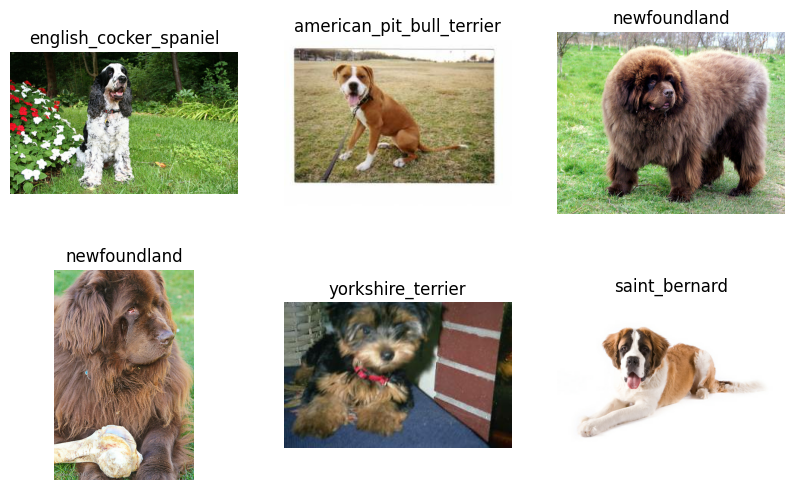

In [27]:
plt.figure(figsize=(10,6))

# Create a mapping from original label indices (from class_names) to the new sequential indices
# within the dog_class_names list.
# dog_labels.numpy() contains the original indices of dog breeds, e.g., [1, 2, 3, ..., 36]
# This map will convert, for example, original index 1 to new index 0,
# original index 2 to new index 1, etc.
label_map = {original_idx: new_idx for new_idx, original_idx in enumerate(dog_labels.numpy())}

for i, (image, label) in enumerate(train_ds.take(6)):
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    # Use the label_map to get the correct sequential index for dog_class_names
    plt.title(dog_class_names[label_map[label.numpy()]])
    plt.axis('off')
plt.show()

In [28]:
IMG_SIZE = 224

# Create a lookup table for remapping labels to 0-indexed values
# label_map is available from cell nkJL97q25GCT
label_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(label_map.keys()), dtype=tf.int64),
        values=tf.constant(list(label_map.values()), dtype=tf.int64)
    ),
    default_value=-1 # Should not be hit if all labels are dog breeds
)

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    remapped_label = label_table.lookup(label) # Remap the label
    return image, remapped_label

train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
counter = Counter()

for _, label in train_ds.unbatch():
    counter[label.numpy().item()] += 1 # Use .item() to get the scalar value

print("Class Distribution:")
for i in range(NUM_CLASSES):
    print(dog_class_names[i], ":", counter[i])

Class Distribution:
american_bulldog : 100
american_pit_bull_terrier : 100
basset_hound : 100
beagle : 100
boxer : 100
chihuahua : 100
english_cocker_spaniel : 96
english_setter : 100
german_shorthaired : 100
great_pyrenees : 100
havanese : 100
japanese_chin : 100
keeshond : 100
leonberger : 100
miniature_pinscher : 100
newfoundland : 96
pomeranian : 100
pug : 100
saint_bernard : 100
samoyed : 100
scottish_terrier : 100
shiba_inu : 100
staffordshire_bull_terrier : 100
wheaten_terrier : 100
yorkshire_terrier : 100


In [30]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [31]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Epoch 1/10
     78/Unknown 97s 1s/step - accuracy: 0.5793 - loss: 1.5312

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


78/78 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5815 - loss: 1.5225 - val_accuracy: 0.8906 - val_loss: 0.3524
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9140 - loss: 0.2745 - val_accuracy: 0.9087 - val_loss: 0.2769
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9543 - loss: 0.1633 - val_accuracy: 0.8934 - val_loss: 0.3301
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.9673 - loss: 0.1151 - val_accuracy: 0.9019 - val_loss: 0.3233
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9840 - loss: 0.0665 - val_accuracy: 0.9131 - val_loss: 0.2796
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9856 - loss: 0.0572 - val_accuracy: 0.9031 - val_loss: 0.3495
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9909 - loss: 0.0375 - val_accuracy: 0.9091 - val_loss: 0.2970
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9950 - loss: 0.0303 - val_accuracy: 0.9063 - val_loss: 0.

In [39]:
model.save("dog_breed_model.h5")
print("Model saved successfully.")

Model saved successfully.


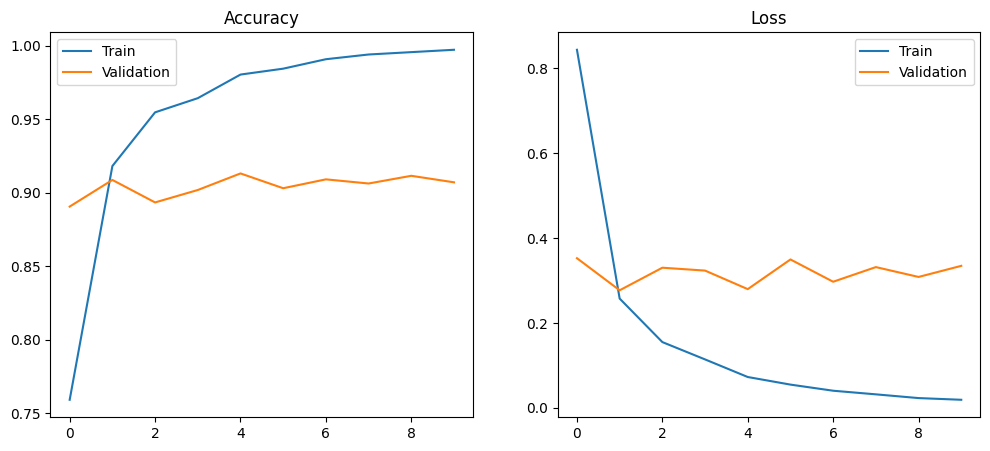

In [33]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()

In [34]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

78/78 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9134 - loss: 0.3352
Test Accuracy: 0.9070796370506287


In [35]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=dog_class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

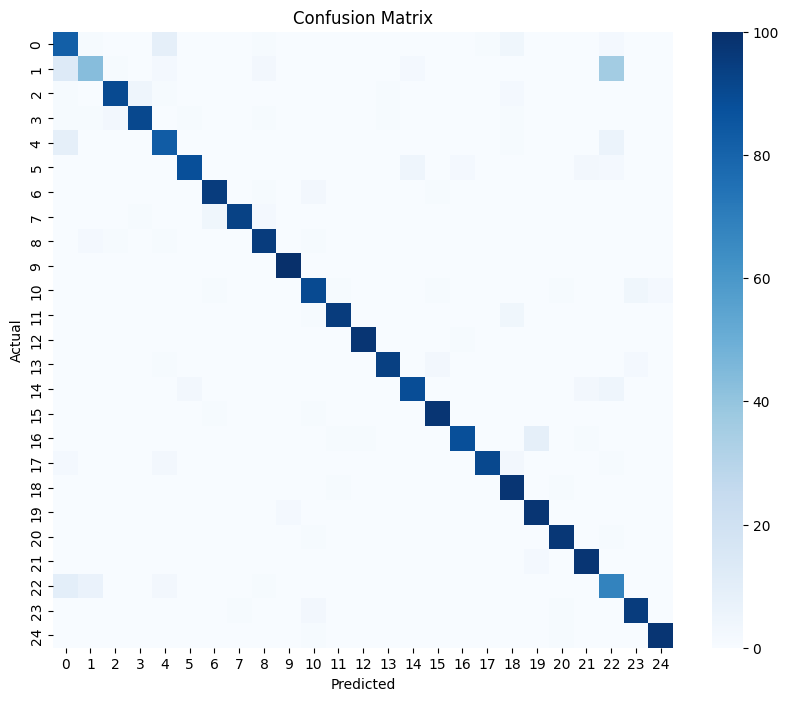

In [36]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [37]:
def predict_and_display(index):
    image, label = list(test_ds.unbatch())[index]
    input_img = tf.expand_dims(image, axis=0)

    probs = model.predict(input_img)[0]
    pred_class = np.argmax(probs)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(f"True: {dog_class_names[label.numpy()]}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.barh(dog_class_names, probs*100)
    plt.title(f"Predicted: {dog_class_names[pred_class]}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


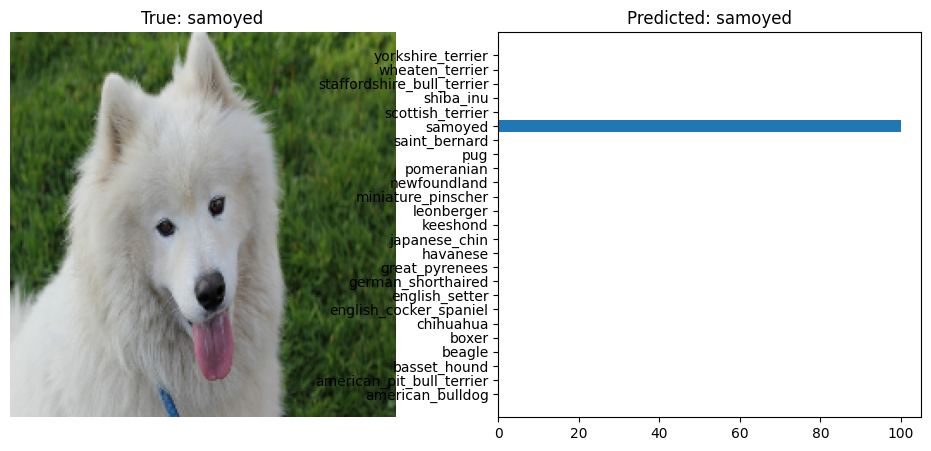

In [38]:
predict_and_display(10)